### Import packages

In [1]:
import numpy as np
import pandas as pd
import prosail as prosaillib

Weird little matplotlib dance...

<AxesSubplot:xlabel='x', ylabel='y'>

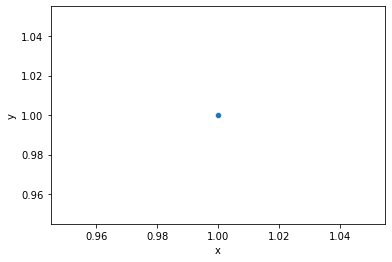

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame(data={ 'x': [1], 'y': [1] })
sns.scatterplot(data=df, x="x", y="y")

In [3]:
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

### Generate random data

In [4]:
from skopt.space.space import Real

DEFAULT_DIMENSIONS = [
    Real(low=1.5, high=1.9, name='n'),
    Real(low=15, high=55, name='cab'),
    #Real(low=5, high=45, name='car'),
    #Real(low=0, high=10, name='cbrown'),
    Real(low=0.002, high=0.01, name='cw'), # ????????
    Real(low=0.005, high=0.010, name='cm'),
    Real(low=0.1, high=8, name='lai'),
    Real(low=0.05, high=0.1, name='hspot'),
    #Real(low=-1, high=-0.99999, name='lidfa'),
    Real(low=0, high=1, name='tts'),
    Real(low=30, high=70, name='tto'),
    Real(low=0, high=340, name='phi'),
]

In [5]:
FILES = [
    (10_000, "prosail_combined", DEFAULT_DIMENSIONS),
]

In [6]:
from skopt.sampler import Lhs

sampler = Lhs(criterion=None)

cnt = 0
def get_random_matrix(n, dimensions):
    global cnt
    cnt += 1
    
    sampled = sampler.generate(dimensions=dimensions, n_samples=n, random_state=cnt)
    return pd.DataFrame(data=sampled, columns=[ x.name for x in dimensions ])

get_random_matrix(1, DEFAULT_DIMENSIONS).iloc[0]

n          1.666809
cab       43.812980
cw         0.002001
cm         0.006512
lai        1.259372
hspot      0.054617
tts        0.186260
tto       43.822429
phi      134.900941
Name: 0, dtype: float64

### Define some PROSAIL functions 

In [7]:
def prosail(params):
    """
    Helper function for prosail
    """
    res = prosaillib.run_prosail(
        n=params['n'],
        cab=params['cab'],
        car=10,#params['car'],
        cbrown=0,#params['cbrown'],
        cw=params['cw'],
        cm=params['cm'],
        lai=params['lai'],
        lidfa=-1,#params['lidfa'],
        hspot=params['hspot'],
        tts=params['tts'],
        tto=params['tto'],
        psi=params['phi'],
        typelidf=1,
        #lidfb=-0.15,
        #typelidf=2,
        prospect_version="D",
        rsoil=0.5,
        psoil=0.5,
    )
    return np.column_stack((np.arange(400, 2500+1), res))

def parse_etm_rsr(rsr_file):
    frames = pd.read_excel(rsr_file, sheet_name=[0, 1, 2, 3, 4, 5, 6])
    #frames = [ frames[key] for key in frames ]
    
    out = frames[0]
    for i in range(1, len(frames)):
        out = pd.merge(out, frames[i], how="outer", on="Wavelength")
        
    if len(out.columns) > 8:
        # HACK: on my pandas this is necessary, but not on all it seems. What is going on?
        out = out.drop(out.columns[2], axis=1)
        
    out = out.fillna(0)
    out.columns = ['Wavelength', 'B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'B8']
    return out.sort_values(by='Wavelength')

def prosail_to_etm(etm_rsr, spectra):
    sel = etm_rsr[etm_rsr['Wavelength'].between(400, 2500)]
    
    spectra = pd.DataFrame(data=spectra, columns=['Wavelength', 'Rho'])
    spectra.loc[:, 'Wavelength'] *= 1000
    
    rho_out = sel.multiply(spectra['Rho'], axis="index")
    band_sum = sel.sum(axis=0)
    
    return (rho_out.sum(axis=0)/band_sum)[1:].to_numpy()
    
etm_rsr = parse_etm_rsr(open('./L7_ETM_RSR.xlsx', 'rb'))

### Test the PROSAIL functions, with a random datapoint

In [8]:
prosail_to_etm(etm_rsr, prosail(get_random_matrix(1, DEFAULT_DIMENSIONS).iloc[0]))

array([0.0070715 , 0.0396134 , 0.01940274, 0.19185559, 0.2006913 ,
       0.19926005, 0.11249161])

###  Generate the training set(s)

In [9]:
def gen_x_y(amount, dimensions):
    params = get_random_matrix(amount, dimensions)
    
    x_train_prosail = np.array([ prosail_to_etm(etm_rsr, prosail(row)) for (_, row) in params.iterrows() ])
    #x_train_prosail = normalize(x_train_prosail, norm='max', axis=0)
    x_train_angles = params[['tts', 'tto', 'phi']]
    #x_train_angles = normalize(x_train_angles, norm='max')
    x_train = np.column_stack((x_train_angles, x_train_prosail))
    
    y_train = np.array([ [row['lai'], row['cm']] for (_,row) in params.iterrows() ])
    
    return (params, x_train, y_train)

In [ ]:
%%time

cols = ['tts', 'tto', 'phi', 'B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'B8', 'lai', 'cm']

for (amount, name, dimensions) in FILES:
    print("gathering for", name)
    (params, x_train, y_train) = gen_x_y(amount, dimensions)
    print(x_train[0], '->', y_train[0])
    
    df = pd.DataFrame(data=np.column_stack((x_train, y_train)), columns=cols)
    df.to_csv("./calculated_{}.csv".format(name))

    params.to_csv('./params_{}.csv'.format(name))

## Generate figures

In [10]:
params = pd.read_csv('./params_prosail_combined.csv', index_col=0)

In [12]:
df = pd.DataFrame(data=[ [ r.name, *r.bounds ] for r in FILES[0][2] ], columns=['name', 'low', 'high']).set_index('name')
print(df.to_latex(bold_rows=True), file = open('graphs/param-space.tex', 'w'))
df

,low,high
name,,
n,1.500,1.90
cab,15.000,55.00
cw,0.002,0.01
cm,0.005,0.01
lai,0.100,8.00
hspot,0.050,0.10
tts,0.000,1.00
tto,30.000,70.00
phi,0.000,340.00


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


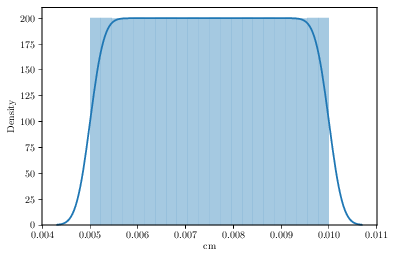

In [13]:
plt.xlabel("cm")
sns.distplot(params['cm'])
plt.savefig('graphs/dist-cm.pdf')

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


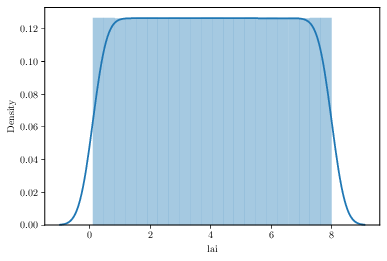

In [14]:
plt.xlabel("LAI")
sns.distplot(params['lai'])
plt.savefig('graphs/dist-lai.pdf')

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


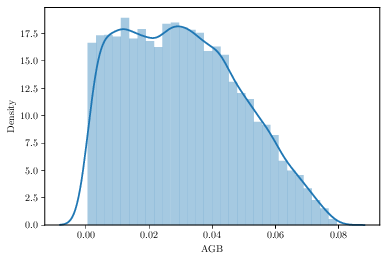

In [15]:
plt.xlabel("AGB")
sns.distplot(params['lai'] * params['cm'])
plt.savefig('graphs/dist-agb.pdf')

### PROSAIL graph

In [16]:
y = [ prosail(row) for (i, row) in params.iterrows() if i < 5000 ]

In [17]:
res = []
for item in y:
    for row in item:
        res.append([row[0], row[1]])
        
df = pd.DataFrame(data=res, columns=["wavelength", "rho"], copy=False)
df[:10]

,wavelength,rho
0,400.0,0.004937
1,401.0,0.004936
2,402.0,0.004935
3,403.0,0.004934
4,404.0,0.004934
5,405.0,0.004934
6,406.0,0.004923
7,407.0,0.004913
8,408.0,0.004904
9,409.0,0.004894


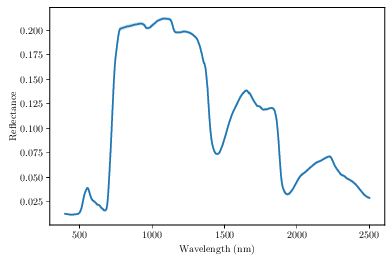

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plot = sns.lineplot(x="wavelength", y="rho", data=df)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.savefig('graphs/prosail.pdf')